# CMB maps with a Generative Adversarial Network
In this tutorial we build a GAN to generate CMB total intensity maps

<img src="GAN_sketch.png" alt="drawing" width="700"/>

first we import the tool necessary to build the training set

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from myfunpy import *

we take the Planck 2018 power spectrum and simulate a CMB maps which is a Gaussian realization of this spectrum

In [2]:
cl = hp.read_cl('Cls_Planck2018_lensed_scalar.fits')[0]
l = np.arange(len(cl))

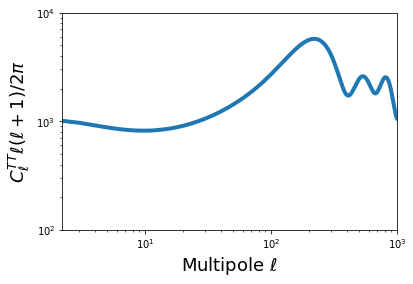

In [3]:
plt.loglog(l, cl*l*(l+1)/np.pi/2., lw=4)
plt.xlim([2.2, 1000])
plt.ylim([1e2, 1e4])
plt.xlabel(r'Multipole $\ell$', fontsize=18)
plt.ylabel(r'$C^{TT}_{\ell}\ell(\ell+1)/2\pi$', fontsize=18)
plt.savefig('cmb_ps.pdf')

In [4]:
cmb_map = hp.synfast(cl, nside=2048, new=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/global/homes/k/krach/usr/python_prefix/lib/python3.6/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/global/homes/k/krach/usr/python_prefix/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/global/homes/k/krach/usr/python_prefix/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


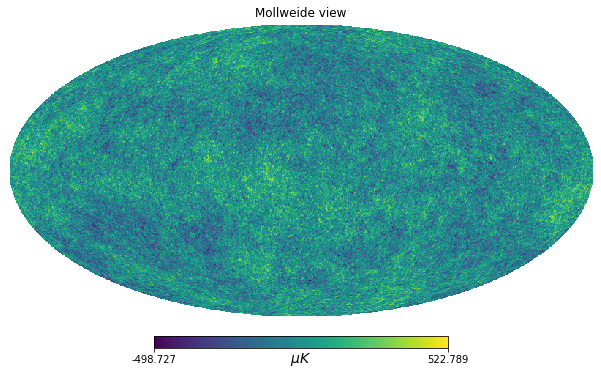

In [5]:
hp.mollview(cmb_map, unit=r'$\mu K$')
plt.savefig('CMB_maps.pdf')

create the training set for the GAN by taking 1000 flat 5°x5° patches with 64x64 pixels each from the full sky map generated above

In [6]:
patch_dim = 5   #dimension of patches in degrees
Npix = 64       #dimension of patches in pixels
reso = patch_dim*Npix/60. #resolution of patches
cmb_patches = []
reso_amin = patch_dim*60./Npix
sizepatch = reso_amin/60.
for N in range(1000):
    lat = np.random.uniform(-90,90)
    lon = np.random.uniform(0,360)
    header = set_header(lon, lat, sizepatch, Npix)
    cmb_patches.append(h2f(cmb_map, header))
cmb_patches = np.array(cmb_patches)
window = (cosine_window(Npix))

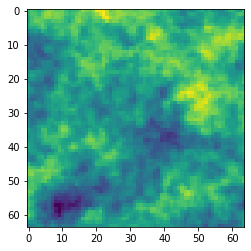

In [7]:
plt.imshow(cmb_patches[2])

We rescale the patches in the range [-1,1]. This is usefull to achieve a better optimization on the GAN.

In [8]:
cmb_res = np.zeros(np.shape(cmb_patches))

def rescale_min_max(img, a=-1, b=1, return_min_max=False):
    img_resc = (b-a)*(img-np.min(img))/(np.max(img)-np.min(img))+a
    if return_min_max:
        return img_resc, np.min(img), np.max(img)
    else:
        return img_resc

for i in range(cmb_patches.shape[0]):
        cmb_res[i] = rescale_min_max(cmb_patches[i])
np.savez('cmb_patches_1000.npz', patches=cmb_res)

here we calculate the factor needed to rescale back the power spectra of the rescaled maps to the original power

In [9]:
cmb_res = np.load('cmb_patches_1000.npz')['patches']
cl_data_tot = []
for i in range(1000):
    ell, cl_data = calculate_2d_spectrum(cmb_res[i]*window, 30, 2000, reso, 64)
    cl_data_tot.append(cl_data)
bias = cl[ell]/np.mean(cl_data_tot, axis=0)

/global/homes/k/krach/usr/python_prefix/lib/python3.6/site-packages/numpy-1.16.2-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/k/krach/usr/python_prefix/lib/python3.6/site-packages/numpy-1.16.2-py3.6-linux-x86_64.egg/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Now, using Keras with tensorflow backend, we build a DCGAN object (Deep Convolutional GAN), in which we define the generator and discriminator CNN and how to train them.

<img src="GAN_summary.png" alt="drawing" width="800"/>

As usual we import the needed modules.

In [10]:
import os
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D,UpSampling2D, Activation, BatchNormalization
from keras.layers import Reshape, Dense, Input
from keras.layers import LeakyReLU, Dropout, Flatten
from keras.optimizers import Adam
from keras import losses
from keras import backend as K

Using TensorFlow backend.


In [11]:
class DCGAN:
    def __init__(self, output_directory, img_size):
        # some parameters
        self.img_size = img_size  #dimension of the input patches in pixels
        self.channels = 1         #number of channel (in this case 1)
        self.kernel_size = 3      #we fix the filters dimension being 3x3
        self.output_directory = output_directory   #directory where to save stuff
        self.latent_dim = 100     # dimension of the noise vector input to the generator

    def smooth_accuracy(self, y_true, y_pred):
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

    def build_generator(self):
        model = Sequential()
        model.add(Dense(128 * 16 * 16, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((16, 16, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation('tanh'))
        noise = Input(shape=(self.latent_dim,))
        img_out = model(noise)
        return Model(noise, img_out)

    def build_discriminator(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        model = Sequential()
        model.add(Conv2D(64, kernel_size=self.kernel_size, strides=1, input_shape=img_shape, padding="same"))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=self.kernel_size, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=self.kernel_size, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        img = Input(shape=img_shape)
        validity = model(img)
        return Model(img, validity)

    def build_gan(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                       optimizer=optimizer,
                                       metrics=['accuracy'])
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        z = Input(shape=(self.latent_dim,))
        fake_img = self.generator(z)
        self.discriminator.trainable = False  #we want to update only G weights
        label = self.discriminator(fake_img)
        self.combined = Model(z, label)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def train(self, epochs, patches_file, batch_size=32, save_interval=100, swap=None, seed=4324, str_run='test'):
        self.build_gan()
        Y_train = np.load(patches_file)['patches']
        print("Training Data Shape: ", Y_train.shape)
        half_batch = batch_size // 2
        accs = []
        for epoch in range(epochs):
            ind_batch = np.random.randint(0, Y_train.shape[0], batch_size)
            ind_hbatch = np.random.randint(0, Y_train.shape[0], half_batch)
            input_noise = np.random.randn(Y_train.shape[0], self.latent_dim)
            input_noise_batch =  np.random.randn(batch_size, self.latent_dim)
            input_noise_hbatch =  np.random.randn(half_batch, self.latent_dim)
            target_fake_gan = np.ones((batch_size, 1))
            
            #traing generator on N fake images
            g_loss = self.combined.train_on_batch(input_noise_batch, target_fake_gan)
            
            real_imgs = Y_train[ind_hbatch]
            real_imgs = real_imgs.reshape((half_batch, self.img_size[0], self.img_size[1], 1))
            fake_imgs = self.generator.predict(input_noise_hbatch)
            target_real_disc = np.ones((half_batch, 1))
            target_fake_disc = np.zeros((half_batch, 1))
            
            # train discriminator on N/2 real and N/2 fake images
            d_loss_real = self.discriminator.train_on_batch(real_imgs, target_real_disc)
            d_loss_fake = self.discriminator.train_on_batch(fake_imgs, target_fake_disc)
            # save progress
            if epoch % (save_interval) == 0:
                print('Epoch: ', epoch)
                save_path = self.output_directory + "/models"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                self.discriminator.save(save_path + '/discrim_'+str_run+str(epoch)+'.h5')
                self.generator.save(save_path + '/generat_'+str_run+str(epoch)+'.h5')
                gen_imgs_tot = self.generator.predict(input_noise)
        self.discriminator.save(save_path + '/discrim_'+str_run+str(epoch)+'.h5')
        self.generator.save(save_path + '/generat_'+str_run+str(epoch)+'.h5')

In [12]:
dcgan = DCGAN(output_directory='./', img_size=(64, 64))

**Note:** training should be done on GPUs, if you are not running on GPUs skip this part and load the pretrained models

In [ ]:
dcgan.train(epochs=2001, patches_file='cmb_patches_1000.npz', batch_size=32, save_interval=1000, str_run='cmb', swap=5)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
test_noise = np.random.randn(1000, 100)
gen_imgs_test = dcgan.generator.predict(test_noise)

In [35]:
gener_pretrained = load_model('./generat_cmb_pretrained.h5')
discrim_pretrained = load_model('./discrim_cmb_pretrained.h5')
gen_imgs_test = gener_pretrained.predict(test_noise)

/usr/common/software/tensorflow/gpu-tensorflow/1.13.1-py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [36]:
gen_imgs_test.shape
cmb_nn = gen_imgs_test[:, :, :, 0]

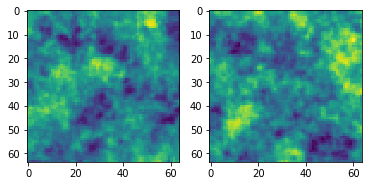

In [45]:
sel = np.random.randint(0, 1000)
cmb_sfl = [cmb_res[sel], cmb_nn[sel]]
sfl = [0, 1]
np.random.shuffle(sfl)
plt.subplot(121)
plt.imshow(cmb_sfl[sfl[0]], vmin=-1, vmax=1)
plt.subplot(122)
plt.imshow(cmb_sfl[sfl[1]], vmin=-1, vmax=1)

In [46]:
if sfl == [0,1]:
    print('Real, Fake')
else:
    print('Fake, Real')

Fake, Real


In [47]:
cmb_res = np.load('cmb_patches_1000.npz')['patches']

In [48]:
cl_nn_tot = []
for i in range(1000):
    ell, cl_nn = calculate_2d_spectrum(cmb_nn[i]*window, 30, 2000, reso, 64)
    cl_nn_tot.append(cl_nn)

(1000.0, 100000.0)

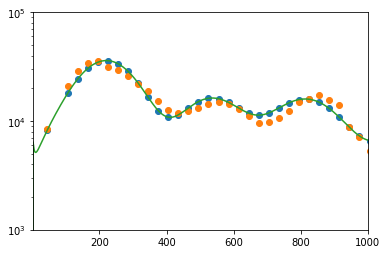

In [49]:
cl_nn_mean = np.mean(cl_nn_tot, axis=0)
cl_data_mean = np.mean(cl_data_tot, axis=0)
plt.semilogy(ell, cl_data_mean*ell*(ell+1)*bias, 'o')
plt.semilogy(ell, cl_nn_mean*ell*(ell+1)*bias, 'o')
plt.semilogy(cl*l*(l+1))
plt.xlim(2, 1000)
plt.ylim(1e3, 1e5)